In [137]:
import sys

import matplotlib.pyplot as plt

import cv2
from drosoph3D.GUI.os_util import *
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d import Axes3D
from drosoph3D.GUI.CameraNetwork import CameraNetwork
import drosoph3D.GUI.skeleton as skeleton
from drosoph3D.GUI.os_util import *
import pickle
import glob
%load_ext autoreload
%autoreload 2
plt.style.use('default')


def map_mesh(low_dim_data, xmax, ymax):
    # frame the x,y coordinates from the low dimensional data.
    mesh = np.zeros(shape=(xmax, ymax))
    point_idx_to_pix = dict()
    pix_to_point_idx = dict()
    for x in range(xmax):
        for y in range(ymax):
            pix_to_point_idx[(x,y)] = list()
    for idx, p in enumerate(low_dim_data):
        x, y = p[0], p[1]
        if x<0 or x>xmax or y<0 or y>ymax:
            continue
        mesh[x, y] += 1
        pix_to_point_idx[(x,y)].append(idx) #each entry(x,y) in this dict is the index of the frame
        point_idx_to_pix[idx] = (x,y) #each entry(frame) in this dict is the postition of the pixel

    return mesh, pix_to_point_idx, point_idx_to_pix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [289]:
x_list = [[], [], [], []]
y_list = [[], [], [], []]
area_list = [[], [], [], []]


d = np.load('/home/user/Desktop/joao_pose/results/15h38m_27_03_2019/tsne_results.pickle')
#filter_list = [['', (0,900)], ['MDN_CsCh', (140, 300)], ['aDN_CsCh', (140,300)], ['PR', (140,140+300)]]
filter_list = [['', (0,900)], ['MDN_CsCh', (0, 900)], ['aDN_CsCh', (0,900)], ['PR', (0,900)]]

for area in d.keys():
    if 'area' in area:
        for path, v in d[area].items():
            for f_idx, f in enumerate(filter_list):
                if f[0] in path:
                    for i in range(10):
                        try:
                            mask = np.logical_and(v[f"sequence_{i}"]['frames']>f[1][0], v[f"sequence_{i}"]['frames']<f[1][1])
                            #mask = np.ones_like(v[f"sequence_{i}"]['frames'], dtype=bool)
                            x_list[f_idx].extend(v[f"sequence_{i}"]['x'][mask])
                            y_list[f_idx].extend(v[f"sequence_{i}"]['y'][mask])
                            area_list[f_idx].extend(np.sum(mask)*[area.replace('area','')])
                        except BaseException as e:
                            continue

x_list = [np.array(x).reshape(-1) for x in x_list]
y_list = [np.array(y).reshape(-1) for y in y_list]

In [91]:
a, b= np.unique(area_list[2], return_counts=True)
print(a,b)
print(a[np.argsort(b)][::-1])
#print(a[b==np.max(b)])

['100' '114' '118' '121' '30' '31' '36' '38' '40' '41' '42' '45' '49' '51'
 '53' '54' '60' '62' '67' '69' '71' '78' '80' '82' '83' '85' '91' '92'
 '95'] [ 47   8 104   9  16  52  83  35 200  31   8 150  15 313  41 273 161  31
  21 140  82 133  25 142 130 479  46 147  14]
['85' '51' '54' '40' '60' '45' '92' '82' '69' '78' '83' '118' '36' '71'
 '31' '100' '91' '53' '38' '41' '62' '80' '67' '30' '49' '95' '121' '42'
 '114']


400
400
400
400


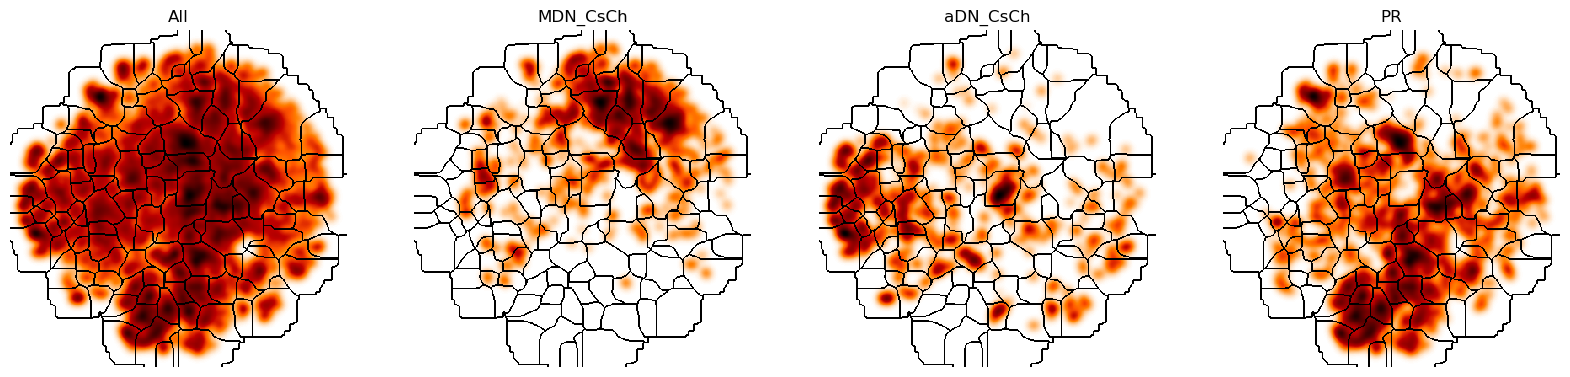

In [290]:
fig, ax_list = plt.subplots(1,4, figsize=(20,20))
title_list = [f[0] for f in filter_list]
title_list[0] = 'All'

for idx, ax in enumerate(ax_list):
    train_tsne_norm = np.concatenate([x_list[idx][:,np.newaxis], y_list[idx][:,np.newaxis]], axis=1)
    print(mag)
    mag = d['2D_tsne_map'].shape[0]
    assert((np.max(train_tsne_norm) < 1) and (np.min(train_tsne_norm)>0))
    xmax, ymax = mag, mag
    train_tsne_norm *= mag
    train_tsne_norm = np.round(train_tsne_norm).astype(np.int)

    assert(np.max(train_tsne_norm)>0)

    grid, pix_to_point_idx, point_idx_to_pix = map_mesh(train_tsne_norm, xmax, ymax)
    #plt.imshow(grid, cmap='viridis')
    #plt.title('t-SNE 2D')

    # Apply 2D Gaussian Convolution
    from scipy.ndimage.filters import gaussian_filter
    from skimage import exposure
    s = 5 #kernel size
    pdf = gaussian_filter(grid, s, order=0, output=None, 
                          mode='nearest', cval=0.0, truncate=4.0)
    
    pdf = (pdf)/norm
    behav_img = (pdf)
    behav_img = behav_img/np.max(behav_img)
    behav_img = np.max(behav_img) - behav_img
    
    from PIL import Image

    # Get the color map by name:
    cm = plt.get_cmap('gist_heat')
    # Apply the colormap like a function to any array:
    behav_img = cm(behav_img)
    x,y = np.where(bord1!=0)
    for x_,y_ in zip(x,y):
        k = 1.0
        for i in np.arange(3):
            behav_img[x_,y_, i] = max(0, behav_img[x_,y_, i]-k)
    
    behav_img = (behav_img*255).astype(np.uint8)
    '''
    #pdf = exposure.adjust_gamma(pdf, 0.3)
    npdf1 = pdf/norm
    #npdf1 = npdf1/norm
    #bord1 = bord1#/(np.max(bord1)*3)
    behav_img = npdf1 + bord1*(norm)
    #npdf1 = bord1*0.00002+npdf1
    #npdf1[npdf1<0.00001] = 0
    #plt.figure()
    ax.imshow(np.max(behav_img)-behav_img, cmap='gist_heat')
    '''
    ax.imshow(behav_img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title_list[idx])
    ax.axis('off')
    #fig.patch.set_visible(False)


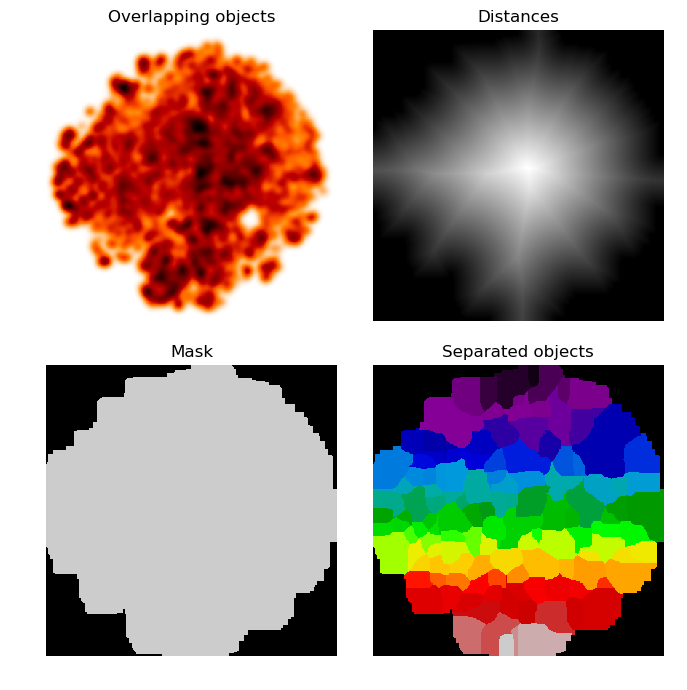

1.0 0.0


/home/user/anaconda3/envs/pose/lib/python3.6/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/user/anaconda3/envs/pose/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int32 to uint8 without scaling because max value 126 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


(-0.5, 399.5, 399.5, -0.5)

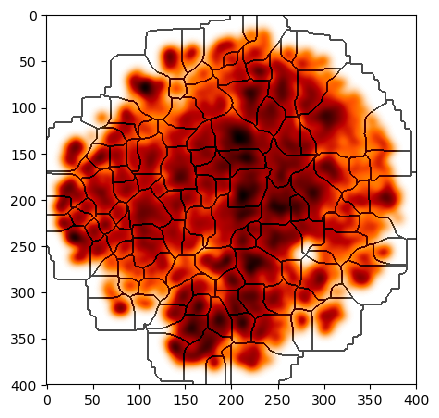

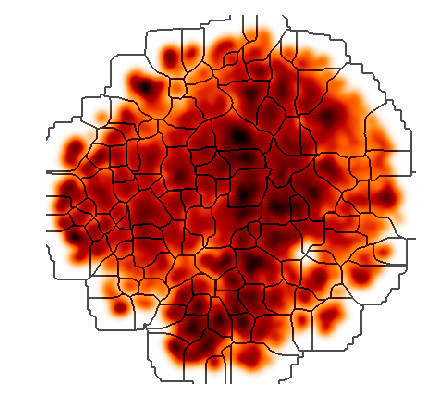

In [277]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

from scipy.ndimage.filters import gaussian_filter
from skimage import exposure

idx = 0
train_tsne_norm = np.concatenate([x_list[idx][:,np.newaxis], y_list[idx][:,np.newaxis]], axis=1)

mag = d['2D_tsne_map'].shape[0]
assert((np.max(train_tsne_norm) < 1) and (np.min(train_tsne_norm)>0))
xmax, ymax = mag, mag
train_tsne_norm *= mag
train_tsne_norm = np.round(train_tsne_norm).astype(np.int)

assert(np.max(train_tsne_norm)>0)
grid, pix_to_point_idx, point_idx_to_pix = map_mesh(train_tsne_norm, xmax, ymax)

s = 5 #kernel size
pdf = gaussian_filter(grid, s, order=0, output=None, 
                      mode='nearest', cval=0.0, truncate=4.0)

pdf = exposure.adjust_gamma(pdf, 1)
rel_tr = 0.01

distance = ndi.distance_transform_edt(pdf)
local_maxi = peak_local_max(pdf, indices=False, threshold_rel=rel_tr, min_distance=5)
markers, num_class = ndi.label(local_maxi)
maske = peak_local_max(pdf, min_distance=0, threshold_rel=0, indices=False)
labels = watershed(-pdf, markers, mask=maske)
segments = watershed(-pdf, labels, connectivity=1, offset=None, mask=maske, compactness=0, watershed_line=False)



fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7), sharex=True, sharey=True)
ax = axes.ravel()
#ax[0].imshow(npdf1, cmap=plt.cm.gray, interpolation='nearest')
ax[0].imshow(np.max(pdf)-pdf, cmap='gist_heat', interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(maske, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[3].set_title('Separated objects')
for a in ax:
    a.set_axis_off()
fig.tight_layout()
plt.show()


from skimage.morphology import disk
from skimage.filters.rank import gradient
gradient = gradient(segments, disk(1))
plt.imshow(gradient, cmap=plt.cm.nipy_spectral, interpolation='nearest')
bord1 = peak_local_max(gradient, min_distance=0, threshold_rel=0, indices=False)
plt.imshow(bord1, cmap='gray_r')

# Create PDF + mask 
#npdf1 = exposure.adjust_gamma(npdf1, 0.3)
norm = np.max(pdf)

#behav_img = np.zeros((npdf1.shape[0], npdf1.shape[1], 3),dtype=np.float)
#behav_img[:,:, 0] = npdf1 / norm
#behav_img[:,:, 1] = bord1/ (np.max(bord1)*3)

pdf = (pdf)/norm
#bord1 = (bord1*50)
behav_img = (pdf)
#behav_img = behav_img/np.max(behav_img)
behav_img = np.max(behav_img) - behav_img
print(np.max(beav_img), np.min(beav_img))

from PIL import Image

# Get the color map by name:
cm = plt.get_cmap('gist_heat')

# Apply the colormap like a function to any array:
behav_img = cm(behav_img)
x,y = np.where(bord1!=0)
for x_,y_ in zip(x,y):
    k = 0.7
    for i in np.arange(3):
        behav_img[x_,y_, i] = max(0, behav_img[x_,y_, i]-k)
        




# Obtain a 4-channel image (R,G,B,A) in float [0, 1]
# But we want to convert to RGB in uint8 and save it:
#im = Image.fromarray((colored_image[:, :, :3] * 255).astype(np.uint8))


plt.imshow(behav_img, cmap='gist_heat')
plt.figure()
plt.imshow(behav_img)
plt.axis('off')

In [249]:
np.max(0, behav_img[x_,y_, 0])

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [212]:
np.where(bord1!=0)

(array([  0,   0,   0, ..., 399, 399, 399]),
 array([198, 199, 212, ..., 200, 251, 252]))